This program will prepare a basic automation routine for functionalizing CO molecules on a clean Cu(111) surface. This program is provided to demonstrate of the automation capabilities for CO-AFM utilizing a CreaTec STM/AFM system. 

Programs from other publications may provide fully-autonomous construction and tip-preparation for STM tips, but here we wish to focus on the basics for CO functionalization:
 - loading the model,
 - utilizing CV tools to help segment your images,
 - functionalizing the tip,
 - using the model to determine the quality of CO functionalization.

This is a tool designed for SPM practitioners who have some understanding of Python programming, machine learning, and hardware automation. Our hope is that hardware manufacturers will integrate some of these techniques into their own programs to aid experimental researchers speed up their own processes. The reason for this program is that automation STM tip preparation has been shown in numerous examples, but functionalization automation is relatively unexplored. 

Keep in mind that automated CO functionalization does not mean taking into account every corner case imaginable. Surface variations, impurities, and cleaning targets will need to be integrated into future models and programs.

In [2]:
### Initialization of libraries ###

#Import libraries is pretty much done. Add any I am missing

import numpy as np
#import win32com.client
import tensorflow as tf
from tensorflow import keras
import cv2
import time

In [3]:
### Load CreaTec scan read parameters ###

# This is the channels that is already listed in the demo scripts

# Channel Selection #
chantopo     = 1
chancurrent  = 2

# Unit Selection #
unit_default = 0
unit_volt    = 1
unit_dac     = 2
unit_ampere  = 3
unit_nm      = 4
unit_Hz      = 5

In [4]:
### Load CreaTec scan parameters ###
# What parameters are these here are they initial or they just in general??



# This assumes a 512x512 pixel size with 400x400 Å size and a scanning speed equivalent to about 5-6 minutes per image. Why?
# This is approximately the limit of reasonable CO imaging and gives you a large area to test with. Too large of an image
# may yield odd CO images. The program will attempt to scale smaller images as well, but your results may be poor.

#used in the score function to start imaging and that is it



def SetScanParameters():
    # Set X x Y image size (Pixels) #
    NumX = 512
    NumY = 512
    stm.setparam('Num.X', NumX)
    stm.setparam('Num.Y', NumY)

    # Set the X x Y image size (Å)
    DeltaX = 119
    DeltaY = 119
    stm.setparam('Delta X [DAC]', DeltaX)
    stm.setparam('Delta Y [DAC]', DeltaY)

    # Set the speed #
    stm.setparam('DX/DDeltaX', 33)
    
    # Set the Topography and Current channels #
    stm.setparam('Channelselectval', 3)

    # Set to Forward + Backward
    stm.setparam('ScanXMode', 0)

    # Set to Constant Current mode #
    stm.setparam('CHMode', 0)

    # Set Bias Voltage (mV) #
    stm.setparam('BiasVolt.[mV]', 100)

    # Set Setpoint Current (pA) #
    stm.setparam('FBLogIset', 50)

In [5]:
### Load point spectra parameters ###
def CO_pickup():
    # Set the voltage #
    stm.setparam('Vpoint0.V', 0)
    stm.setparam('Vpoint0.V', 2600)
    stm.setparam('Vpoint0.V', 2600)
    stm.setparam('Vpoint0.V', 2600)
    stm.setparam('Vpoint0.V', 0)

    # Set the time #
    stm.setparam('Vpoint0.t', 0)
    stm.setparam('Vpoint0.t', 20)
    stm.setparam('Vpoint0.t', 500)
    stm.setparam('Vpoint0.t', 980)
    stm.setparam('Vpoint0.t', 1000)

    # Set the parameters #
    stm.setparam('Vertchannelselectval',4097)
    stm.setparam('Vertmangain', 6)
    stm.setparam('Vertmandelay', 100) # Need to calculate this value (clock cycle)
    stm.setparam('VertSpecBack', 0)
    stm.setparam('VertSpecAvrgnr', 1)
    stm.setparam('VertAvrgdelay', 100)
    stm.setparam('VertRepeatCounter', 1)
    stm.setparam('VertLineCount', 2)
    stm.setparam('VertFBMode', 4)
    stm.setparam('VertFBLogiset', 0.400)
    stm.setparam('VertLatddx', 15.223)
    stm.setparam('VertLatdelay', 166)

In [6]:
def CO_dropoff():
    # Set the voltage #
    stm.setparam('Vpoint0.V', 0)
    stm.setparam('Vpoint0.V', 3300)
    stm.setparam('Vpoint0.V', 3300)
    stm.setparam('Vpoint0.V', 3300)
    stm.setparam('Vpoint0.V', 0)

    # Set the time #
    stm.setparam('Vpoint0.t', 0)
    stm.setparam('Vpoint0.t', 20)
    stm.setparam('Vpoint0.t', 500)
    stm.setparam('Vpoint0.t', 980)
    stm.setparam('Vpoint0.t', 1000)

    # Set the parameters #
    stm.setparam('Vertchannelselectval', 4097)
    stm.setparam('Vertmangain', 6)
    stm.setparam('Vertmandelay', 100) # Need to calculate this value (clock cycle)
    stm.setparam('VertSpecBack', 0)
    stm.setparam('VertSpecAvrgnr', 1)
    stm.setparam('VertAvrgdelay', 100)
    stm.setparam('VertRepeatCounter', 1)
    stm.setparam('VertLineCount', 2)
    stm.setparam('VertFBMode', 4)
    stm.setparam('VertFBLogiset', 0.400)
    stm.setparam('VertLatddx', 15.223)
    stm.setparam('VertLatdelay', 166)

In [7]:
# Start a Scan
def RunScan():
    stm.scanstart()
    while stm.scanstatus > 0:
        time.sleep(0.1)

In [8]:
### Read the scan image ###
def ReadSTMImage(channel, unit):
    image_STM = stm.scandata(channel,unit)
    image = np.asarray(image_STM)
    return image

In [9]:
### Normalize the image for import into OpenCV ###
def NormalizeSTMImage(image):
    # Normalize the image which is needed for later usage in OpenCV tools.
    img_n = cv2.normalize(src=image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img_n

In [10]:
### Size filter to remove points with areas significantly larger features ###
def FilterCO(kp):
    # Gather the CO sizes
    s = [int(kp[i].size) for i in range(len(kp))]
    
    # Extract COs based on the feature size. This is needed for SURF, where the feature detection and CO points are somewhat
    # correlated. A better way to do this is HoughCircle in OpenCV, but this has a habit of detecting COs at the edge.
    kp_XY = [kp[i].pt for i in range(len(kp)) if kp[i].size <= np.median(s)]
    
    # Extract the CO sizes. This value isn't really used, but was in testing.
    kp_size = [kp[i].size for i in range(len(kp)) if kp[i].size <= np.median(s)]
    return s, kp_XY, kp_size

In [11]:
# Generate mask for COs for import into empty area function
def GenerateCOMask(image, kp_XY):
    # Extract dimensions from image
    height, width = image.shape[:2]

    # Generate a blank mask of all zeros
    binaryMap = np.zeros((width, height))

    # Extract the points from the filtered CO list and convert to X,Y lists
    CO_list = [(int(element[0]), int(element[1])) for element in kp_XY]
    
    # Generate a circle mask around each point of similar size to the original radius
    for i in range(len(CO_list)):
        cv2.circle(binaryMap,(CO_list[i][0],CO_list[i][1]),int(np.median(s)/2),(255,255,255),thickness=-1)

    # Output a binary map
    th, dst = cv2.threshold(binaryMap, 0, 255, cv2.THRESH_BINARY)
    
    return th, dst

In [12]:
### Crop and Store COs ###
def CropCO(norm_image,kp_XY):
    # Set an empty array to fill with images
    CO_crop = np.array([])

    # Crop each CO with input size to feed into model
    for i in range(len(circles)):
        
        # Set a zoom to gather the entire CO (center +surrounding halo)
        zoom = 1.5
        # Convert the kp coordinates for easier reference
        kp_coord = kp_XY[i].pt
        
        # Set the radius to include zoom value. Expands the surrounding rectangle (square)
        radius = (kp_XY[i].size/zoom).astype("int")
        
        # Crop at the target coordinates
        CO_crop.append(norm_image[kp_coord[0]-radius:kp_coord[1]+radius, kp_coord[0]-radius:kp_coord[1]+radius])
    return CO_crop

In [13]:
def FindEmptySquareArea(mat, ZERO=0):
    #Find the largest square of ZERO's in the matrix `mat`.
    #Source: https://stackoverflow.com/a/1726667
    
    # Extract array shape
    nrows, ncols = mat.shape
    
    # Check for null array / empty matrix or rows
    if not (nrows and ncols):
        return 0
    
    # Initiate null array based on row and column sizes
    counts = np.zeros((nrows, ncols))
    
    # For each row
    for i in reversed(range(nrows)):
        # The matrix must be rectangular (actually square)
        assert len(mat[i]) == ncols
        
        # For each element in the row
        for j in reversed(range(ncols)):
            
            # If the element is zero, check around it
            if mat[i][j] == ZERO:
                counts[i][j] = (1 + min(
                    counts[i][j+1],   # east
                    counts[i+1][j],   # south
                    counts[i+1][j+1]  # south-east
                    )) if i < (nrows - 1) and j < (ncols - 1) else 1  # edges
    mx = -1
    lx = -1
    ly = -1
    for row in range(len(counts)):
        for col in range(len(counts[row])):
            if counts[row, col] > mx:
                mx = counts[row, col]
                ly = row
                lx = col

    return mx, ly, lx

In [14]:
def FindEmptySquareAreaPosition(img):
    # Returns the Y,X center of the largest empty square in an image and size.
    # Prints a nice reference image for sanity check.
    mx, ly, lx = FindEmptySquareArea(img, 0)
    
    # Calculate the center
    ly = ly+mx/2
    lx = lx+mx/2
    
    # Visual output of the square
    # Normalize the image
    img = (img-img.min())/(img.max()-img.min())
    img *= 255
    ly = int(ly)
    lx = int(lx)

    # Draw a box around the edge of the square
    img[int(ly),int(lx)]=255
    img[int(ly-1),int(lx-1)]=255
    img[int(ly-1),int(lx+1)]=255
    img[int(ly+1),int(lx-1)]=255
    img[int(ly+1),int(lx+1)]=255
    for i in range(int(mx)):
        img[int(ly+i-mx/2),int(lx-mx/2)] = 255
        img[int(ly+i-mx/2),int(lx+mx-mx/2)] = 255
        img[int(ly-mx/2),int(lx+i-mx/2)] = 255
        img[int(ly+mx-mx/2),int(lx+i-mx/2)] = 255
        
    # Print the image (quick reference)
    #plt.imshow(img, cmap = "gray");
    return ly, lx, mx

In [15]:
### Initialize CreaTec STMAFM program ###
#stm = win32com.client.Dispatch("pstmafm.stmafmrem")

In [16]:
### Import Keras model ###
print("/CNN_tf/model.hf")

reconstructed_model = tf.keras.models.load_model("./CNN_tf/model.h5")

/CNN_tf/model.hf


79
(152, 282)
(175, 17)


NameError: name 'numpy' is not defined

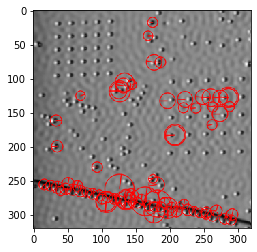

In [55]:
### Simplified program to run autonomous CO functionalization on a single scan area ###
import matplotlib.pyplot as plt
score = 0
target = 0.9
CO_count = 0
pulse = 0

while score < target:
    # Load STM Scan Parameters #
    #SetScanParameters()
    
    # Start Scan #
    #RunScan()
    
    # Load STM Image #
    stm_image = cv2.imread('cooncu.png', 0)
    #print(stm_image)
    
    # Convert to Image Format Compatible with SURF
    norm_image = NormalizeSTMImage(stm_image)
    #print(norm_image)
    
    # Load SURF parameters 
    surf = cv2.xfeatures2d.SURF_create(1200)
    
    # Find keypoints and descriptors
    kp, des = surf.detectAndCompute(norm_image,None)
    print (len(kp))
    
    # If no COs, alert operator
    if len(kp) == 0:
        print("No objects detected. Please check scan area or image dimensions.")
        break
    
    # Filter out non-CO positions
    s, kp_XY, kp_size = FilterCO(kp)
    #print(kp_XY)
    
    # Plot the SURF identified features
    surf_image = cv2.drawKeypoints(norm_image,kp,None,(255,0,0),4)
    plt.imshow(surf_image);
    
    # Extract the points from the filtered CO list and convert to X,Y lists
    CO_list = [(int(element[0]), int(element[1])) for element in kp_XY]
    print(CO_list[:][0])
    print(CO_list[:][1])
    ar3 = numpy.concatenate([CO_list[:][0], CO_list[:][1]])
    ### Sort the centerpoints from top to bottom, left to right ###
    CO_list_sorted = CO_list[np.lexsort(ar3)]
    
    # Generate a CO mask to identify empty areas
    CO_mask = GenerateCOMask(norm_image, CO_list_sorted)
    
    # Crop and Store CO images
    # Cropped images need to be scaled to 32x32 images for analysis by model
    CO_crop = CropCO(norm_image, circles)
    CO_crop = np.array(CO_crop, dtype="object")
    resized_CO = np.array([cv2.resize(np.copy(CO_crop), (32, 32)) for CO in CO_crop])
    
    # Analyze with model
    add_norm_CO(resized_CO)
    outputs = model.predict_on_batch(resized_CO)
    probs = np.squeeze(np.array(outputs))
    score = np.median(probs)
    
    if CO_count >= 10:
        # Load dropoff parameters
        print("Hello")
        #CO_dropoff()
        
        # Target tip to an empty area
        #ly, lx, mx = FindEmptySquareAreaPosition(CO_mask)
        
        # Run vertical manipulation
        #stm.btn_vertspec(lx, ly)
        
        # Brief sleep due to STMAFM program quirks
        time.sleep(0.05)
        
        # Track the number of tip pulses
        pulse += pulse
        
        # Reset counter back to 0
        CO_count = 0
    else:
        # Score comparison
        # Typically if the score is less than 0.005, this is, from initial tests, no CO.
        # Not always true, but further refinements of the program needed to detect blank or extremely tilted COs.
        if score < 0.005:
            
            # Load pickup parameters
            #CO_pickup()
            
            # Run vertical manipulation at first point in list
            #stm.btn_vertspec(CO_list_sorted[0][0], CO_list_sorted[0][1])
            
            # Brief sleep due to STMAFM program quirks
            time.sleep(0.05)
            
            # Track the number of attempted CO pickups
            CO_count += CO_count
        
        # For scores between 0.005 and the target, CO or O-terminated is already attached. Drop-off is needed.
        elif score >= 0.005 and score < target:
            
            # Load dropoff parameters
            print("Goodbye")
            #CO_dropoff()

            # Target tip to an empty area
            #ly, lx, mx = FindEmptySquareAreaPosition(CO_mask)

            # Run vertical manipulation
            #stm.btn_vertspec(lx, ly)

            # Brief sleep due to STMAFM program quirks
            time.sleep(0.05)

            # Track the number of tip pulses
            pulse += pulse

        # Final condition is greater than or equal to target, which means that the model identifies the image as CO-terminated
        # within the target parameters. 
        else:
            print("CO termination completed")
            print("Target: ", target)
            print("Score:", score)
            print("# of Pulses: ", pulse)